<a href="https://colab.research.google.com/github/Elman295/Unsupervised-Domain-Adaptation-by-Backpropagation-/blob/main/UDA_by_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn

#`Data`

In [2]:
tfms = transforms.Compose([
    transforms.Resize(size = (28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.5, std = 0.5)
])

In [3]:
mnist_train = datasets.MNIST(
    root = "data",
    download = True,
    train = True,
    transform = tfms
)

mnist_test = datasets.MNIST(
    root = "data",
    download = True,
    train = False,
    transform = tfms
)

usps_train = datasets.USPS(
    root = "data",
    download = True,
    train = True,
    transform = tfms
)

usps_test = datasets.USPS(
    root = "data",
    train = False,
    download = True,
    transform = tfms
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 19872318.06it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 666642.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5640188.03it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 988046.72it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 6579383/6579383 [00:01<00:00, 4981399.57it/s]


100%|██████████| 1831726/1831726 [00:01<00:00, 1795044.52it/s]


In [4]:
class DANN_data(Dataset):

  def __init__(self, data, type_data):
    self.data = data
    self.type_data = type_data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    label_domain = 0
    image, label = self.data[idx]

    if self.type_data == "target":
      label_domain = 1

    return image, label, label_domain



In [5]:
source_train = DANN_data(mnist_train, type_data="source")
source_test = DANN_data(mnist_test, type_data="source")

target_train =DANN_data(usps_train, type_data="target")
target_test =  DANN_data(usps_test, type_data="target")

In [6]:
source_train_dl = DataLoader(dataset = source_train, batch_size = 32, shuffle = True)
source_test_dl = DataLoader(dataset = source_test, batch_size = 32, shuffle = False)

target_train_dl = DataLoader(dataset = target_train, batch_size = 32, shuffle = True)
target_test_dl = DataLoader(dataset = target_test, batch_size = 32, shuffle = False)

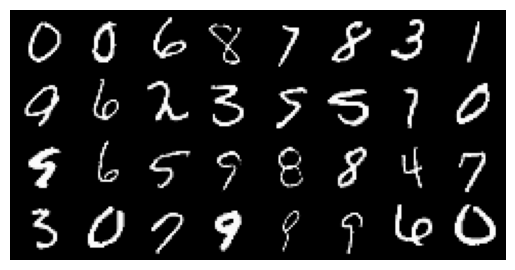

In [7]:
image,label, domain = next(iter(source_train_dl))
outs = torchvision.utils.make_grid(image)
plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()

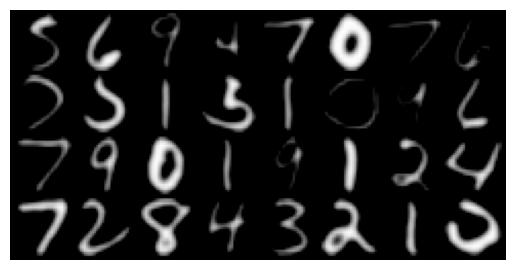

In [8]:
image,label, domain = next(iter(target_train_dl))
outs = torchvision.utils.make_grid(image)
plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()

#`Function`

In [9]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        return x.view_as(x)


    @staticmethod
    def backward(self, grad_output):
        return (grad_output * -1)

def GRL(x):
    return GradReverse.apply(x)

#`Models`

In [10]:
class DANN(nn.Module):

  def __init__(self):
    super(DANN, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(1,16,5,1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.predictor = nn.Sequential(
        nn.Linear(5*5*32,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,10)
    )

    self.domain_classifier = nn.Sequential(
        nn.Linear(5*5*32,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,2)
    )



  def forward(self, x):
    features = self.feature_extractor(x)
    # print(features.shape)
    features = features.view((-1,5*5*32))
    classes = self.predictor(features)
    domain = self.domain_classifier(GRL(features))
    return classes, domain



In [11]:
dann = DANN()
x = torch.rand(size = (32,1,28,28))
y,d = dann(x)
print(y.shape)
print(d.shape)

torch.Size([32, 10])
torch.Size([32, 2])


#`Optimizer and Loss functions`

In [12]:
optimizer = torch.optim.Adam(params = dann.parameters(), lr = 1e-3)
loss_cls = nn.CrossEntropyLoss()
loss_d = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma = 0.9)

#`Train and Test`

In [13]:
def train(data_s, data_t, model, loss_fn_classifier, loss_fn_domain, opt, scheduler):
  model.train()
  size = len(data_s.dataset)

  for b , ((x_s,y_s,d_s),(x_t,_,d_t)) in enumerate(zip(data_s, data_t)):

    cls_s,domain_s = model(x_s)
    cls_t, domain_t = model(x_t)
    loss_1 = loss_fn_classifier(cls_s, y_s)
    loss_2 =  loss_fn_domain(domain_t, d_t)
    loss_3 = loss_fn_domain(domain_s,d_s)
    loss = loss_1 + loss_2 + loss_3
    opt.zero_grad()
    loss.backward()
    opt.step()

  scheduler.step()

  if b % 100 == 0:
    print(f"[{b*len(x_s)} | {size}]  loss : {loss.item()}")
    print(f"scheduler: {scheduler.get_lr()}")




In [14]:
def test(data, model, loss_fn):
  model.eval()
  size = len(data.dataset)
  num_batch = len(data)
  test_loss, test_acc = 0,0

  with torch.no_grad():
    for x,y,_ in data:
      y_pred, _ = model(x)
      test_loss += loss_fn(y_pred, y).item()
      test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batch
    test_acc /= size

    print(f"loss : {test_loss} acc:{test_acc * 100}")


In [16]:
for epoch in range(5):
  print(f"epoch:{epoch+1}=-=-=-=-=")
  train(source_train_dl, target_train_dl, dann, loss_cls, loss_d,optimizer,scheduler)
  test(target_test_dl, dann, loss_cls)
  test(source_test_dl, dann, loss_cls)

epoch:1=-=-=-=-=
loss : 0.9407269055881198 acc:68.65969108121574
loss : 0.15912250031125003 acc:95.3
epoch:2=-=-=-=-=
loss : 1.2462638753747184 acc:65.67015445939212
loss : 0.13546600438233766 acc:95.55
epoch:3=-=-=-=-=
loss : 0.8247567419967954 acc:74.43946188340807
loss : 0.15750678669233187 acc:95.24000000000001
epoch:4=-=-=-=-=
loss : 0.8348631527688768 acc:75.9840558046836
loss : 0.17292085793070175 acc:94.49
epoch:5=-=-=-=-=
loss : 0.7902249381655738 acc:75.08719481813652
loss : 0.12939357864239012 acc:95.89999999999999
